In [160]:
import sys
sys.path.append('../../')
from search import search_local_distance
import numpy as np
from tools.tools import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Get gaia catalogue distance and distance error

In [161]:
samples = search_local_distance.get_entire_catalogue()
dist, dist_err = samples.T

Define parammeters for making histogram. All units in kpc.

In [180]:
d_pixel = 0.001
d_max = np.max(dist)
d_min = 0
bins = int((d_max - d_min)/d_pixel)
epsilon = 0.05
bins_close = int((epsilon - d_min)/d_pixel)

Get stars within epsilon kpc around sun as well as their error.

In [181]:
mask = dist < epsilon
dist_close = dist[mask]
dist_close_err = dist_err[mask]

Graph 1D histogram for distribution of distance for all of gaia catalogue

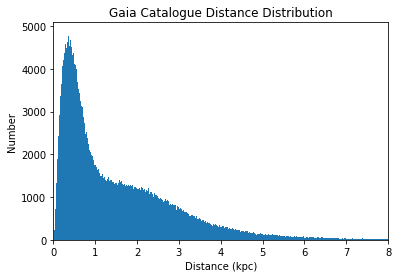

In [193]:
plt.figure(1)
histogram_gaia, edges, patches = plt.hist(dist, bins = bins)
plt.xlim((d_min, 8.0))
plt.xlabel("Distance (kpc)")
plt.ylabel("Number")
plt.title("Gaia Catalogue Distance Distribution")
plt.savefig("Gaia Catalogue Distance Distribution.png")

Graph 1D histogram for distribution of distance for all stars in epsilon region

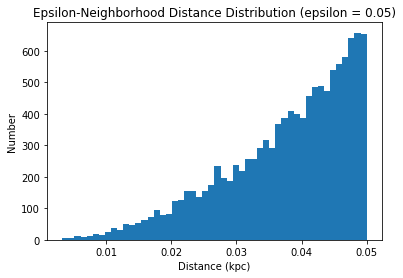

In [182]:
plt.figure(2)
histogram_close, edges_close, patches_close = plt.hist(dist_close, bins = bins_close)
plt.xlabel("Distance (kpc)")
plt.ylabel("Number")
plt.title("Epsilon-Neighborhood Distance Distribution (epsilon = {})".format(epsilon))
plt.savefig("Epsilon-Neighborhood Distance Distribution (epsilon = {}).png".format(epsilon))

Define a function that get the gaia spherical number density function from histogram result

In [183]:
def n_gaia(d, histogram):
    d_index = ((d-d_min)/d_pixel).astype(int)-1
    result = []
    for i in range(np.size(d)):
        result.append(histogram[d_index[i]])
    return np.array(result)

Get the numpy array of n_gaia applied to the whole catalogue as well as epsilon region

In [184]:
n_gaia_array = n_gaia(dist, histogram_gaia)
n_gaia_close_array = n_gaia(dist_close, histogram_close)

Define the true sperhical number density function

In [185]:
def n(d, n_0):
    return n_0*4*(np.pi)*(d**2)

Curve fit spherical density with stars in epsilon region.

In [186]:
popt, pcov = curve_fit(n, dist_close, n_gaia_close_array)
n_0 = popt[0]
std_n_0 = pcov[0][0]
print("optimized n_0 =", n_0)
print("standard deviation of n_0 =", std_n_0)

optimized n_0 = 20799.609187268637
standard deviation of n_0 = 93.77125707573454


Plot theoretical prediction over histogram in epsilon neighborhood.

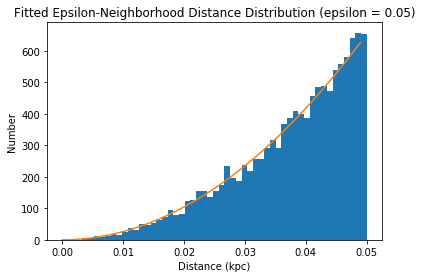

In [187]:
plt.figure(3)
plt.hist(dist_close, bins = bins_close)
d_linspace = np.linspace(d_min, epsilon, bins_close, endpoint = False)
plt.plot(d_linspace, n(d_linspace, n_0))
plt.xlabel("Distance (kpc)")
plt.ylabel("Number")
plt.title("Fitted Epsilon-Neighborhood Distance Distribution (epsilon = {})".format(epsilon))
plt.savefig("Fitted Epsilon-Neighborhood Distance Distribution (epsilon = {}).png".format(epsilon))

Get the distance and index of the point where number of stars start decreasing

In [188]:
drop_index = histogram_gaia.argmax()
d_drop = d_min + drop_index*d_pixel

Plot theoretical prediction over real histogram for all stars.

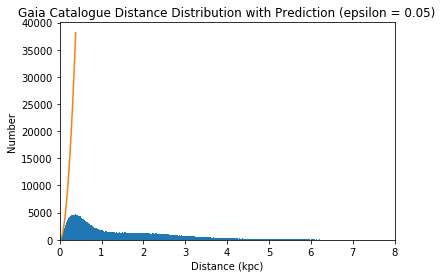

In [189]:
plt.figure(4)
plt.hist(dist, bins = bins)
plt.xlim((d_min, 8.0))
d_linspace = np.linspace(d_min, d_drop, bins, endpoint = False)
plt.plot(d_linspace, n(d_linspace, n_0))
plt.xlabel("Distance (kpc)")
plt.ylabel("Number")
plt.title("Gaia Catalogue Distance Distribution with Prediction (epsilon = {})".format(epsilon))
plt.savefig("Gaia Catalogue Distance Distribution with Prediction (epsilon = {}).png".format(epsilon))

Plot the fractional accuracy of prediction against real; use the fraction n_gaia/n, so that it starts off close to 1 and then drop to zero since there is increasingly small samples the farther we are from the sun.

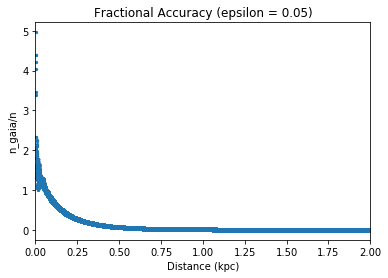

In [190]:
plt.figure(5)
plt.scatter(dist, n_gaia_array/n(dist, n_0), s=5)
plt.xlim(d_min, 2.0)
plt.xlabel("Distance (kpc)")
plt.ylabel("n_gaia/n")
plt.title("Fractional Accuracy (epsilon = {})".format(epsilon))
plt.savefig("Fractional Accuracy (epsilon = {}).png".format(epsilon))

Calculate the Pearson Chi Square statistic

In [191]:
def reduced_chi_squared(N,n,y,y_x):
    #N is number of observation
    #n is number of parameters
    #y is an array of points from the measurements
    #y_x is an array of points that are the outputs from the model function

    v = N-n #define a convenient value
    # run a for loop to sum up a series of terms
    # first initialize the sum
    sum = 0
    for i in range(N):
        sum += (y[i] - y_x[i])**2
    return sum/v

In [192]:
N = np.size(dist_close)
num_parameter = 1
chi_squared = reduced_chi_squared(N, num_parameter, n_gaia_close_array,
                                  n(dist_close, n_0))
print(chi_squared)

471.82588045605416
